In [ ]:
#importing the Libraries
import numpy as np
import itertools
import pandas as pd
import os
import math
import random
import cv2
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from imgaug import augmenters as iaa
from tqdm.notebook import tqdm

In [ ]:
# Setting training and test directories as global variable
train_dir = "../input/plant-seedlings-classification/train/"
test_dir = "../input/plant-seedlings-classification/test/"
save_dir = "/kaggle/working/plant-seedlings-classification/train"
target_size = (224, 224)

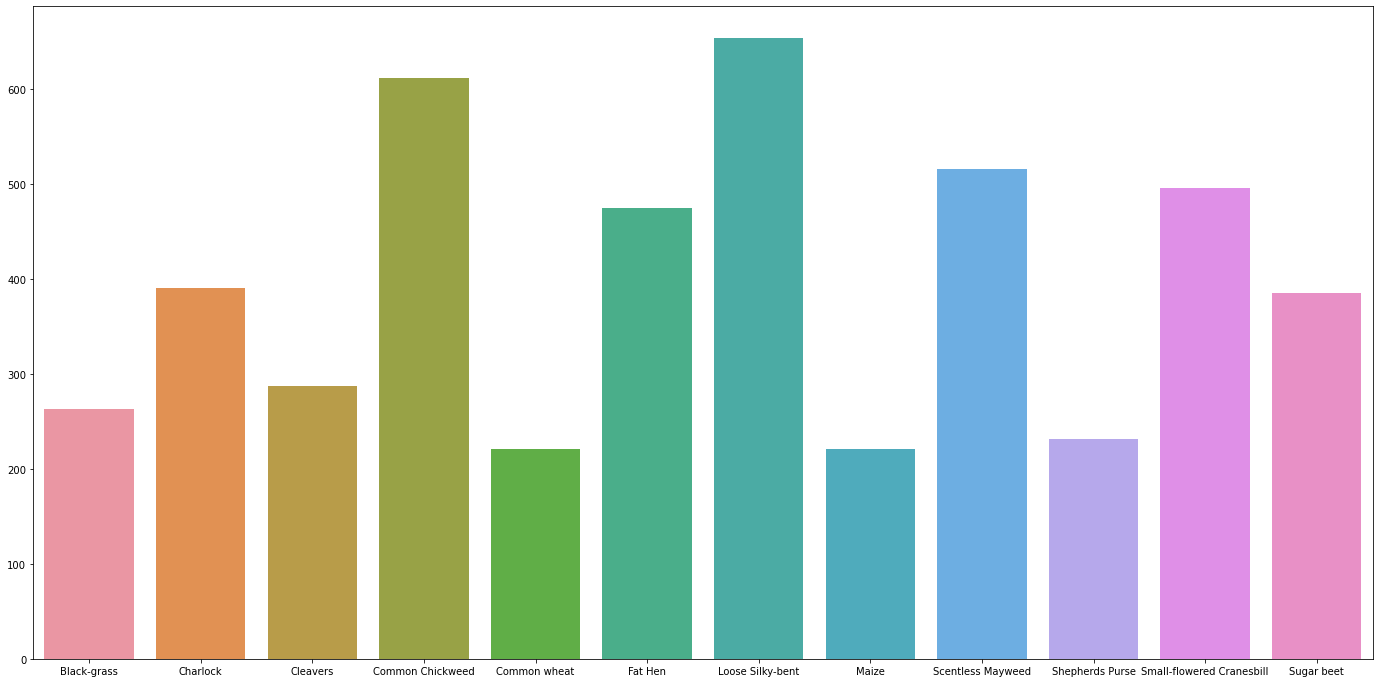

In [ ]:
# List of all the categories 
categories = [category for category in sorted(os.listdir(train_dir))]

# For getting the number of images in each cateogry
images_per_category = [len(os.listdir(os.path.join(train_dir, category))) for category in categories]

# Visualization
plt.figure(figsize=(24,12))
sns.barplot(categories, images_per_category)

We can see there is the case of unbalanced data, so we need to balance it

In [ ]:
class DataLoader():
   
    
    def __init__(self, **kwargs):
        
        self.train_dir = kwargs.get('train_dir')
        self.test_dir = kwargs.get('test_dir')
        self.save_dir = kwargs.get('save_dir')
        self.segmentation = kwargs.get('segmentation')
        self.target_size = kwargs.get('target_size')
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        self.data_og = [self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path)) for category in categories for img_path in os.listdir(os.path.join(self.train_dir, category))]
        if self.segmentation:
            self.data_seg = [self.segmentation_pipeline(self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path))) for category in categories for img_path in os.listdir(os.path.join(self.train_dir, category))]
            
        
    
    #For Creating a binary mask for a given HSV range
    def create_mask_for_plant(self, image):
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_hsv = np.array([25, 50, 50])
        upper_hsv = np.array([95, 255, 255])
        mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        return mask

  
    # Use the binary mask to segment the image
    def segment_plant(self, image):
        mask = self.create_mask_for_plant(image)
        output = cv2.bitwise_and(image, image, mask = mask)
        return output

    
    # Sharpen the segmented image for contrast
    def sharpen_image(self, image):
        image_sharp = cv2.bilateralFilter(image, 11, 11, 11) 
        return image_sharp

   
    # Augment passed images
    def augment_images(self, class_images):
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(rotate=(-45, 45)),
            iaa.TranslateX(percent=(-0.1, 0.1)),
            iaa.TranslateY(percent=(-0.1, 0.1))
        ], random_order=True)

        images_aug = seq(images = class_images)
        return images_aug

    
    # Randomly sample images from a set of passed images
    def random_unique_sampling(self, class_images, remainder):
        random_unique_indices = random.sample(range(0, len(class_images)), remainder)
        random_unique_images = [class_images[idx] for idx in random_unique_indices]
        return random_unique_images
        

    def augmentation_pipeline(self, class_images, number_of_images):
        """Accepts a batch of images (of a single class) and returns a required number of augmented images"""

        if number_of_images == 0:
                return []

        elif number_of_images >= len(class_images):
            batches = math.floor(number_of_images / len(class_images))
            remainder = number_of_images % len(class_images)
            remainder_images = self.random_unique_sampling(class_images, remainder)
            class_images = class_images * batches
            class_images.extend(remainder_images)
            images_aug = self.augment_images(class_images)
            return images_aug

        else:
            assert number_of_images < len(class_images)
            class_images = self.random_unique_sampling(class_images, number_of_images)
            images_aug = self.augment_images(class_images)
            return images_aug
        
    def preprocessing_pipeline(self, path):
        """Accepts a path and returns a processed image involving reading and resizing"""
        image = cv2.resize(cv2.imread(path), self.target_size, interpolation = cv2.INTER_NEAREST)
        return image


    def segmentation_pipeline(self, image):
        """Accepts an image and returns a HSV segmented version of the image"""
        image_segmented = self.segment_plant(image)
        image_sharpen = self.sharpen_image(image_segmented)
        return image_sharpen
    
    
    def balance_dataset(self):
        """Create augmented data to balance classes from the passed training data path"""
        
        # Make a directory for augmented dataset
        os.makedirs(self.save_dir, exist_ok=True)
        
        # Get categories
        categories = [category for category in sorted(os.listdir(self.train_dir))]

        # Get the maximum amount of images that exists in a class
        max_in_class = max([len(os.listdir(os.path.join(self.train_dir, category))) for category in categories])

        # Find out the augmentations required for each class
        images_per_category = {category : len(os.listdir(os.path.join(self.train_dir, category))) for category in categories}

        # Find out the augmentations required for each class
        required_augmentations = dict(zip(categories,  [max_in_class - num_in_class for num_in_class in list(images_per_category.values())]))

        # Augment each unbalanced class and save the new dataset to disk
        # We preferring saving the data to disk
        # Because we prefer to not hold large numpy arrays in the RAM
        # This allows for large models to be loaded and trained on
        # We use for loops here instead of list comprehensions for readiblity
        for category in tqdm(categories):
            try:
                os.mkdir(os.path.join(self.save_dir, category))
            except FileExistsError:
                pass
            class_images = list()

            # Preprocessing and Augmentation
            for img_path in sorted(os.listdir(os.path.join(self.train_dir, category))):
                image = self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path))
                if self.segmentation == True:
                    image = self.segmentation_pipeline(image)
                class_images.append(image)
            augmented_images = self.augmentation_pipeline(class_images, required_augmentations[category])
            class_images.extend(augmented_images)

            # Writing the augmented data to disk
            for image_number, class_image in enumerate(class_images):
                cv2.imwrite(os.path.join(self.save_dir, category, "{}.png".format(image_number + 1)), class_image)
        
    def load_for_train(self, model):
        
        if model == "resnet50":
            datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        elif model == "inception_v3":
            datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
            target_size = (299, 299)
        elif model == 'vgg16':
            datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        else:
            sys.exit('Fatal Error: Invalid Model Requested.')


        train_generator = datagen.flow_from_directory(
                directory= os.path.join(self.save_dir),
                target_size= self.target_size,
                class_mode = "categorical",
                batch_size=32,
                shuffle=True,
                subset='training'
            )
        
        val_generator = datagen.flow_from_directory(
                directory= os.path.join(self.save_dir),
                target_size= self.target_size,
                class_mode = 'categorical',
                batch_size=32,
                shuffle=False,
                subset='validation'
            )

        return train_generator, val_generator
        
    def load_for_viz(self, model):
        
        if model == "resnet50":
            datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        elif model == "inception_v3":
            datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
            target_size = (299, 299)
        elif model == 'vgg16':
            datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        else:
            sys.exit('Fatal Error: Invalid Model Requested.')

        generator = datagen.flow_from_directory(
        directory= os.path.join(self.save_dir),
        target_size= self.target_size,
        batch_size=1,
        class_mode=None,
        shuffle=False
        )
        
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        max_in_class = max([len(os.listdir(os.path.join(self.train_dir, category))) for category in categories])
        categories_rep = list(itertools.chain.from_iterable(itertools.repeat(x, max_in_class) for x in categories))
        data_df = pd.DataFrame(categories_rep, columns = ["categories"])
        
        return generator, data_df
    
    def load_for_inference(self):
        
        test_images = np.array([self.segmentation_pipeline(self.preprocessing_pipeline(os.path.join(self.test_dir, img_path))) for img_path in sorted(os.listdir(self.test_dir))])
        filenames = [filename for filename in sorted(os.listdir(self.test_dir))]
        return test_images, filenames
        
    
    def show_sample_images(self):
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        random_indices = random.sample(range(0, len(self.data_og)), 4)
        
        # Plot some sample images from the dataset
        _, axs = plt.subplots(1, 4, figsize=(20, 20))
        for i in range(4):
            axs[i].imshow(self.data_og[random_indices[i]])
        
        # Plot segmented images if segmentation is True
        if self.segmentation:
            _, axs = plt.subplots(1, 4, figsize=(20, 20))
            for i in range(4):
                axs[i].imshow(self.data_seg[random_indices[i]])
            

In [ ]:
class Utilities:
    
    def __init__(self, train_dir, save_dir):
        self.train_dir = train_dir
        self.save_dir = save_dir
        
        
    def plot_tSNE(self, data_df, base_model, generator, title):
        
        feature_vector = base_model.predict_generator(generator, 7848, verbose =1)
        print('Extratced feature dimensionality: {}'.format(feature_vector.shape))
        tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
        tsne_results = tsne.fit_transform(feature_vector)
        
        data_df['tsne-2d-one'] = tsne_results[:,0]
        data_df['tsne-2d-two'] = tsne_results[:,1]

        plt.figure(figsize=(20,16))
        plt.title("tSNE Visualization - " + title)
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="categories",
            palette=sns.color_palette("hls", 12),
            data=data_df,
            legend="full",
            alpha=0.3
        )
        plt.savefig(os.path.join(os.path.normpath(self.save_dir + os.sep + os.pardir), title + ".png"), dip=300, bbox_inches='tight')
        
    def summarize_model(self, history_model, model, val_generator):
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        self.plot_curves(history_model)
        self.plot_classification_metrics(categories, model, val_generator)


    def plot_curves(self, history_model):
        plt.style.use('seaborn')

        # for getting the Summary history for accuracy
        plt.figure(1, figsize=(16, 10))
        plt.plot(history_model.history['accuracy'])
        plt.plot(history_model.history['val_accuracy'])
        plt.title('Train and Validation Accuracy', fontsize = 16)
        plt.ylabel('Accuracy', fontsize = 14)
        plt.xlabel('Epoch', fontsize = 14)
        plt.legend(['Train', 'Validation'], fontsize = 14)
        plt.show()

        # for getting the Summary history for loss
        plt.figure(2, figsize=(16, 10))
        plt.plot(history_model.history['loss'])
        plt.plot(history_model.history['val_loss'])
        plt.title('Train and Validation Loss', fontsize = 16)
        plt.ylabel('Loss', fontsize = 14)
        plt.xlabel('Epoch', fontsize = 14)
        plt.legend(['Train', 'Validation'], fontsize = 14)
        plt.show()

   #defining classification_metrics function for the plot
    def plot_classification_metrics(self, categories, model, val_generator):

        predictiions = model.predict_generator(val_generator, 48)
        y_pred = np.argmax(predictiions, axis=1)
        cf_matrix = confusion_matrix(val_generator.classes, y_pred)
        print('Classification Report')
        print(classification_report(val_generator.classes, y_pred, target_names=categories))
        plt.figure(figsize=(20,20))
        sns.heatmap(cf_matrix, annot=True, xticklabels=categories, yticklabels=categories, cmap='Blues')
        
        
    def infer(self, test_images, model):
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        predictions = model.predict(test_images, batch_size = 32)
        y_pred = np.argmax(predictions, axis = 1)
        y_pred_categories = [categories[i] for i in y_pred]
        return y_pred_categories
        
        
    def make_csv(self, y_pred_categories, filenames, save_path):
        inference = pd.DataFrame(zip(filenames, y_pred_categories), columns = ['Filename', "Prediction"])
        inference.to_csv(os.path.join(save_path, "inference.csv"))
        print('Saved inferences to disk!')

In [ ]:
# Making object
dataloader = DataLoader(train_dir = train_dir, test_dir = test_dir, save_dir = save_dir, target_size = target_size, segmentation = True)

# Initialize Utilities
utils = Utilities(train_dir, save_dir)

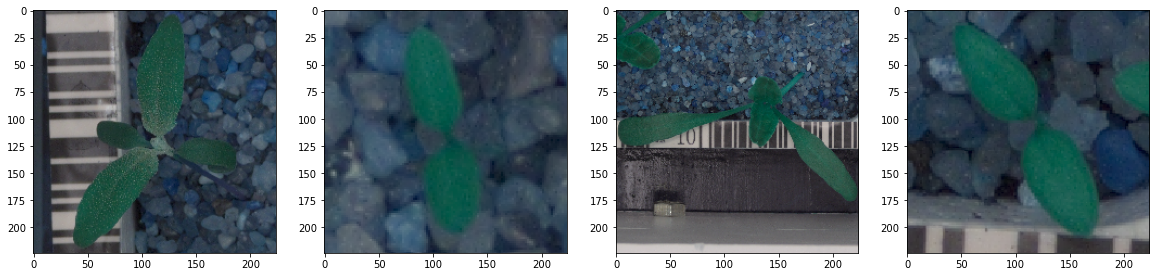

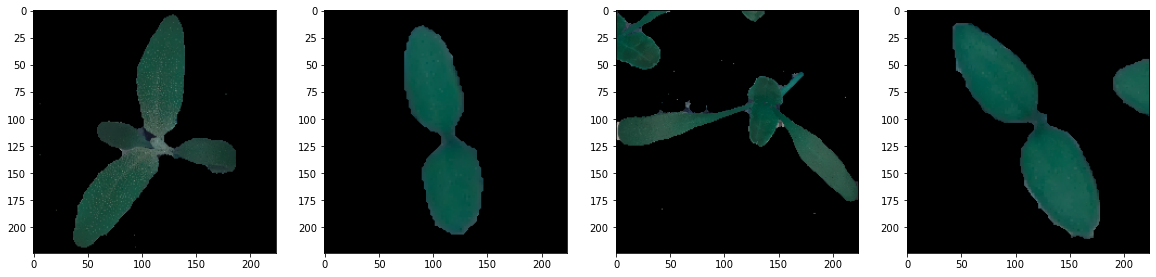

In [ ]:
#visualizing some sample images
dataloader.show_sample_images()



In [ ]:
dataloader.balance_dataset()

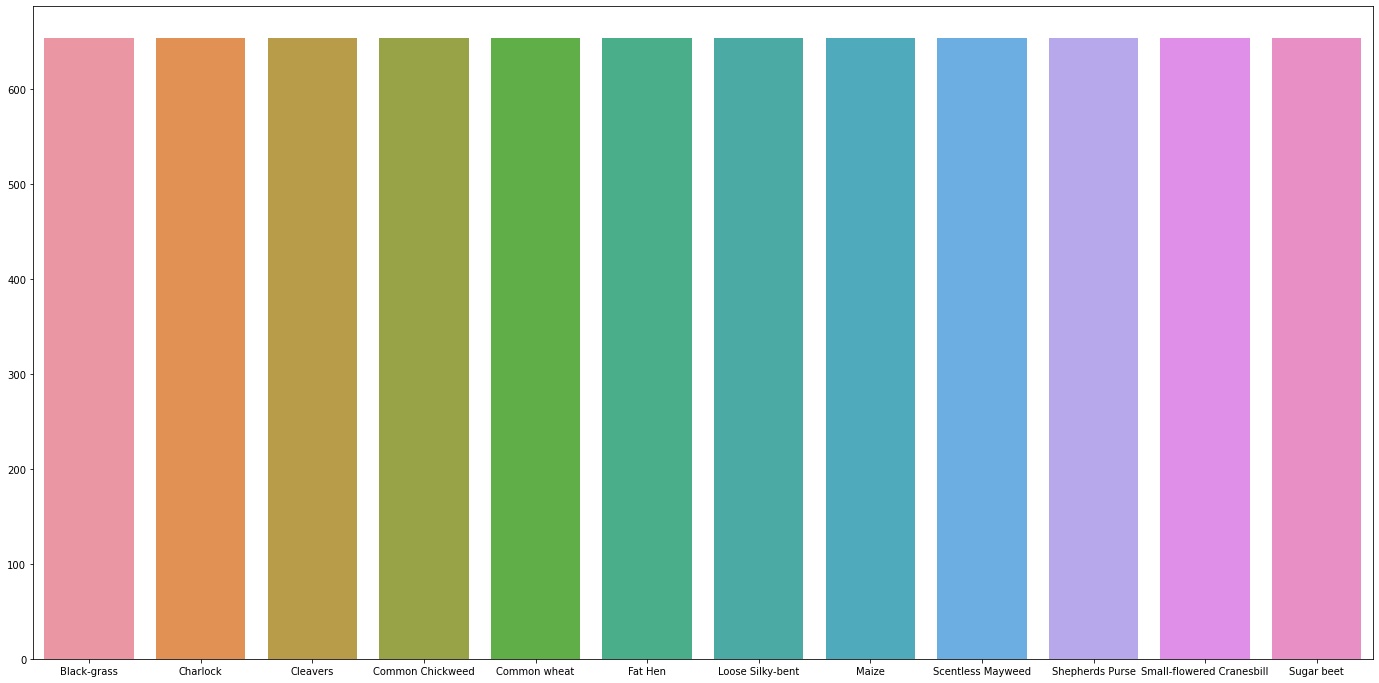

In [ ]:
# Get names of all the categories 
categories = [category for category in sorted(os.listdir(save_dir))]

# Get the number of images in each cateogry
images_per_category = [len(os.listdir(os.path.join(save_dir, category))) for category in categories]

# Plot to see the distribution
plt.figure(figsize=(24,12))
sns.barplot(categories, images_per_category)

**1- Using Inceptionv3**

Now, we can see from the above visualization that the data is balanced now

In [ ]:
# Loading generators
train_generator, val_generator = dataloader.load_for_train(model = "inception_v3")

# callbacks
model_save_path = '/kaggle/working/model_inceptionv3'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/18
196/196 [==============================] - 24s 122ms/step - loss: 1.9903 - accuracy: 0.3400 - val_loss: 1.1369 - val_accuracy: 0.6743
Epoch 2/18
196/196 [==============================] - 17s 89ms/step - loss: 0.9977 - accuracy: 0.7011
Epoch 3/18
196/196 [==============================] - 18s 92ms/step - loss: 0.6232 - accuracy: 0.8139
Epoch 4/18
196/196 [==============================] - 18s 93ms/step - loss: 0.4270 - accuracy: 0.8782
Epoch 5/18
196/196 [==============================] - 18s 90ms/step - loss: 0.3089 - accuracy: 0.9148
Epoch 6/18
196/196 [==============================] - 18s 90ms/step - loss: 0.2266 - accuracy: 0.9401
Epoch 7/18
196/196 [==============================] - 18s 92ms/step - loss: 0.1649 - accuracy: 0.9613
Epoch 8/18
196/196 [==============================] - 18s 91ms/step - loss: 0.1289 - accuracy: 0.9719
Epoch 9/18
196/196 [==============================] - 18s 89ms/step - loss: 

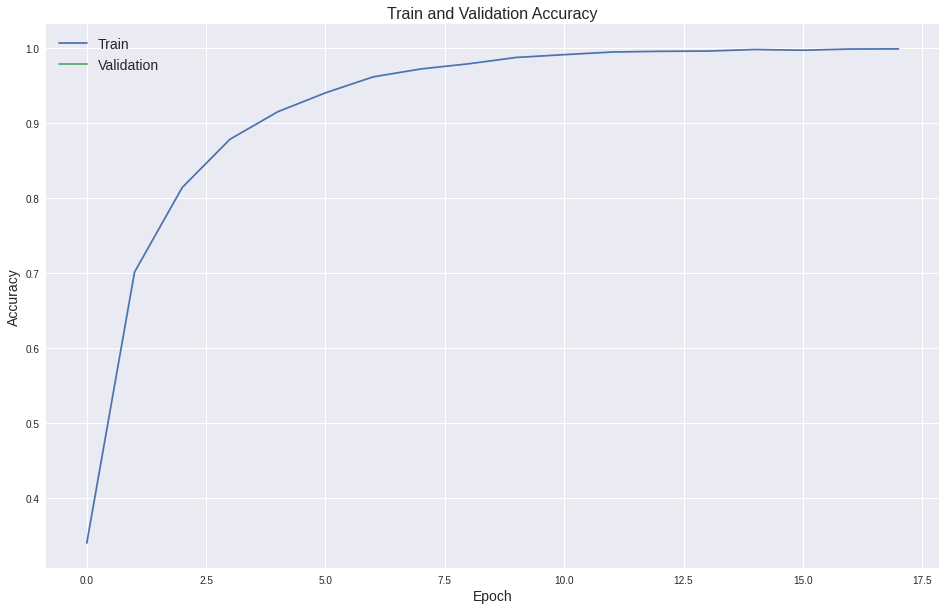

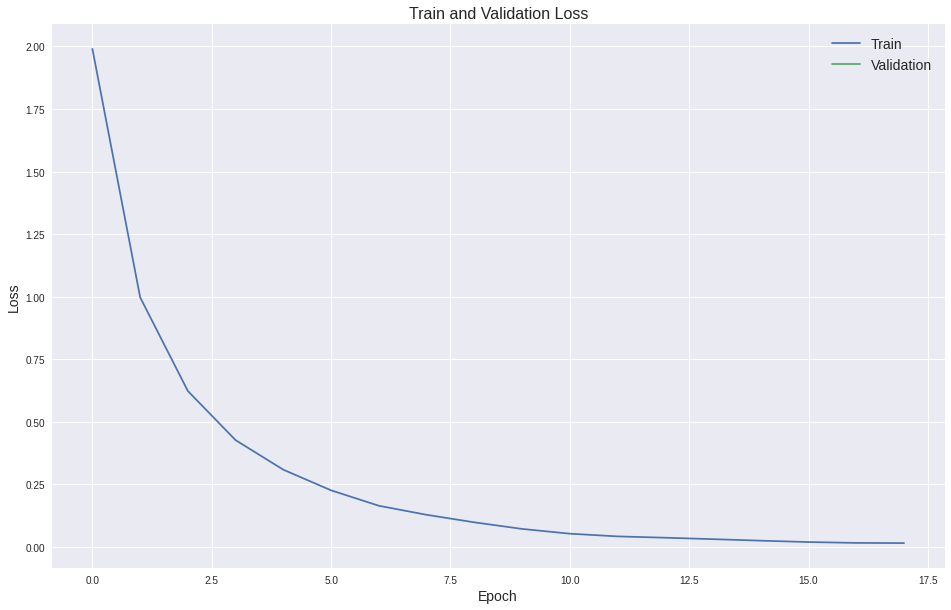

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.78      0.47      0.59        98
                 Charlock       1.00      1.00      1.00        98
                 Cleavers       0.99      0.91      0.95        98
         Common Chickweed       0.91      0.98      0.95        98
             Common wheat       0.91      0.95      0.93        98
                  Fat Hen       0.91      0.95      0.93        98
         Loose Silky-bent       0.61      0.86      0.71        98
                    Maize       1.00      0.97      0.98        98
        Scentless Mayweed       0.88      0.94      0.91        98
          Shepherds Purse       0.93      0.88      0.91        98
Small-flowered Cranesbill       1.00      0.98      0.99        98
               Sugar beet       0.96      0.93      0.94        98

                 accuracy                           0.90      1176
                macro avg       0.91  

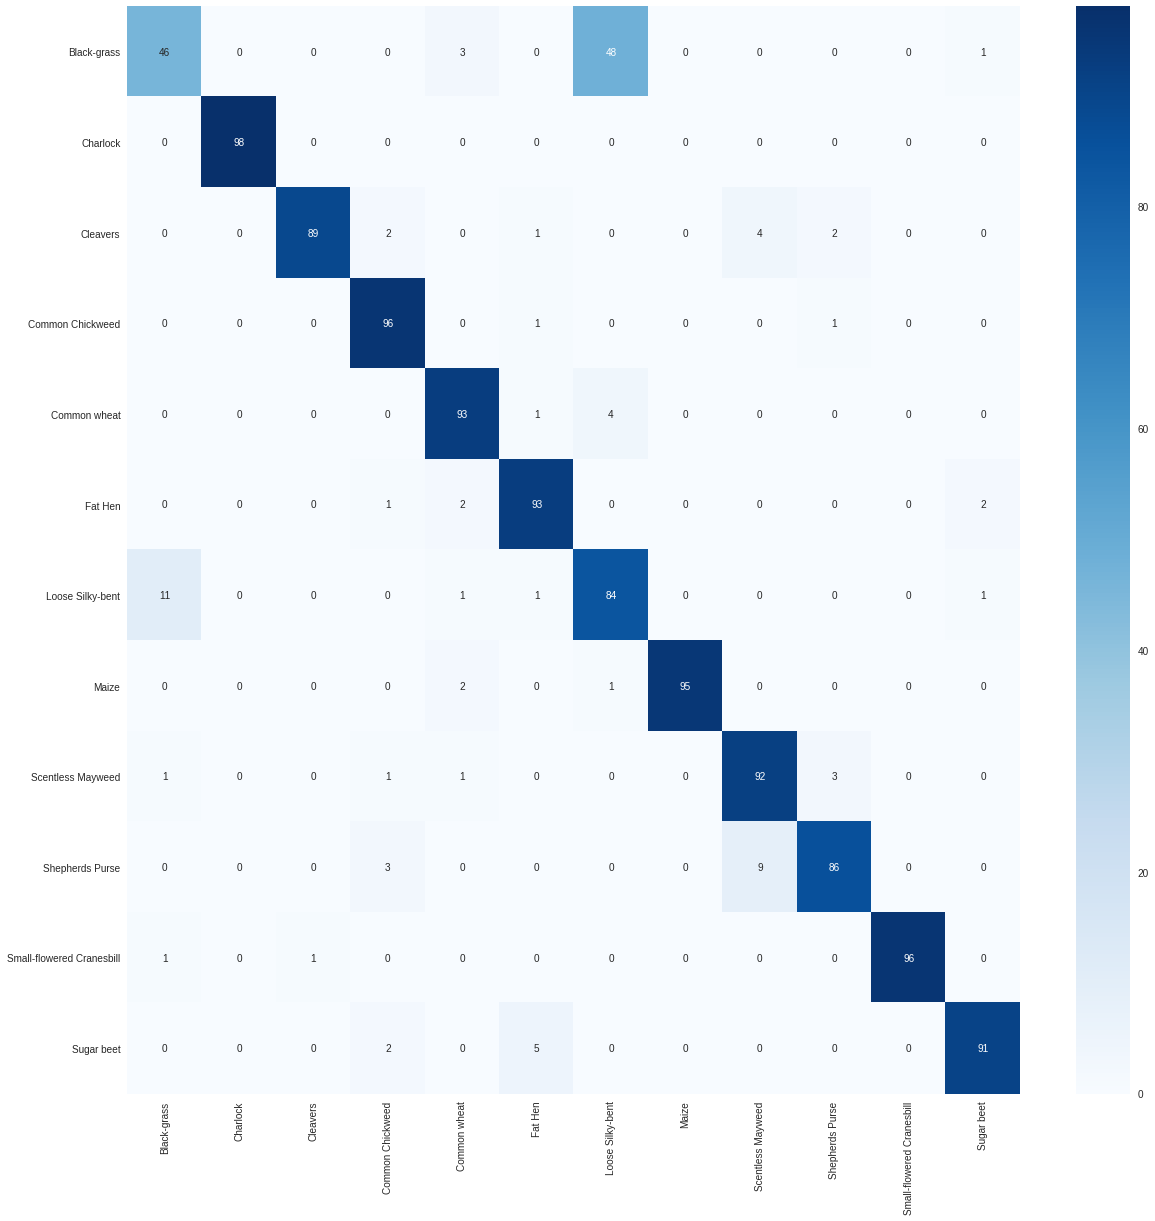

In [ ]:
# Configure model for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299, 299, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:152]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_inception_v3 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 18,
                      verbose = 1,
                      callbacks = [reduce_lr, early_stop])

# Save the model
model.save(model_save_path)

# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_inception_v3, model, val_generator)

**2 - Using resnet50**

In [ ]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "resnet50")

# Define callbacks
model_save_path = '/kaggle/working/model_resent50'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)



Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


Epoch 1/18
196/196 [==============================] - 27s 136ms/step - loss: 1.7572 - accuracy: 0.4321 - val_loss: 0.7296 - val_accuracy: 0.7551
Epoch 2/18
196/196 [==============================] - 22s 112ms/step - loss: 0.6168 - accuracy: 0.8122
Epoch 3/18
196/196 [==============================] - 22s 112ms/step - loss: 0.3422 - accuracy: 0.8983
Epoch 4/18
196/196 [==============================] - 22s 114ms/step - loss: 0.2244 - accuracy: 0.9361
Epoch 5/18
196/196 [==============================] - 22s 113ms/step - loss: 0.1509 - accuracy: 0.9564
Epoch 6/18
196/196 [==============================] - 22s 114ms/step - loss: 0.1116 - accuracy: 0.9686
Epoch 7/18
196/196 [==============================] - 22s 113ms/step - loss: 0.0783 - accuracy: 0.9805
Epoch 8/18
196/196 [==============================] - 22s 113ms/step - loss: 0.0554 - accuracy: 0.9874
Epoch 9/18
196/196 [==============================] - 23s 116ms/step - loss: 0.0435 - accuracy: 0.9891
Epoch 10/18
196/196 [==========

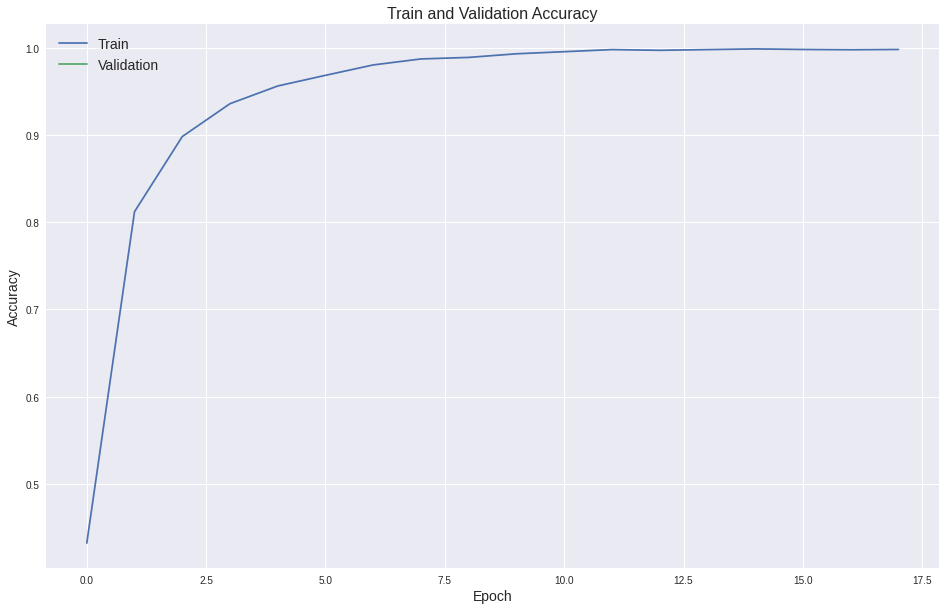

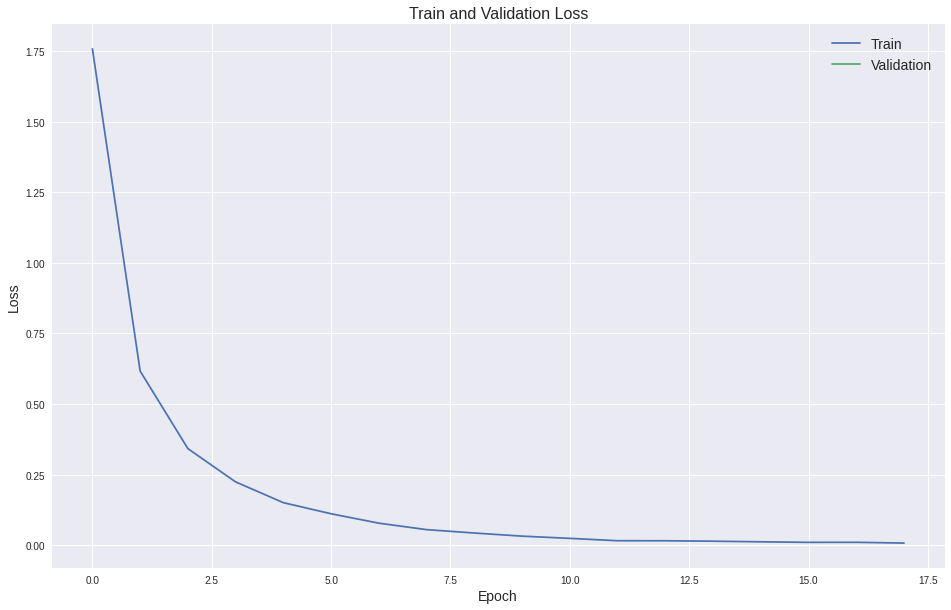

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.87      0.60      0.71        98
                 Charlock       1.00      0.99      0.99        98
                 Cleavers       1.00      0.97      0.98        98
         Common Chickweed       0.97      1.00      0.98        98
             Common wheat       0.96      0.96      0.96        98
                  Fat Hen       0.98      0.98      0.98        98
         Loose Silky-bent       0.68      0.91      0.78        98
                    Maize       1.00      0.99      0.99        98
        Scentless Mayweed       0.88      0.96      0.92        98
          Shepherds Purse       0.98      0.89      0.93        98
Small-flowered Cranesbill       1.00      0.99      0.99        98
               Sugar beet       0.98      0.98      0.98        98

                 accuracy                           0.93      1176
                macro avg       0.94  

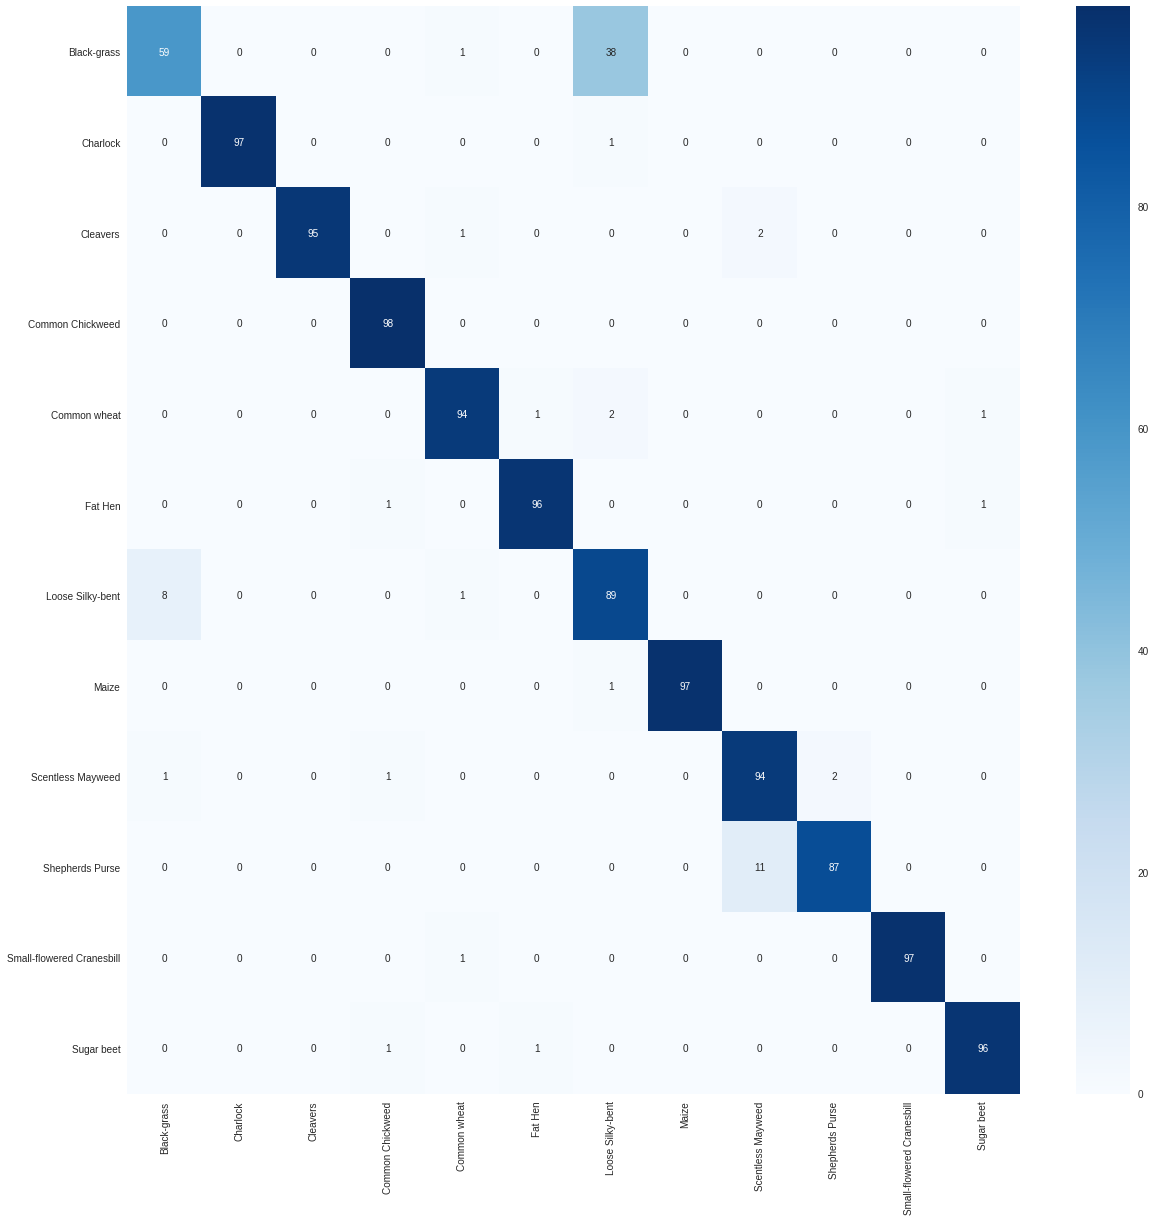

In [ ]:
# Configure model for transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:81]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_resent50 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 18,
                      verbose = 1,
                      callbacks = [reduce_lr, early_stop])

# Save the model
model.save(model_save_path)

# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_resent50, model, val_generator)

**3 - Using vgg16**

In [ ]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "vgg16")

# Define callbacks
model_save_path = '/kaggle/working/model_vgg16'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


Epoch 1/18
196/196 [==============================] - 24s 123ms/step - loss: 2.1310 - accuracy: 0.3008 - val_loss: 0.9961 - val_accuracy: 0.6658
Epoch 2/18
196/196 [==============================] - 20s 102ms/step - loss: 0.8546 - accuracy: 0.7072
Epoch 3/18
196/196 [==============================] - 20s 102ms/step - loss: 0.4616 - accuracy: 0.8473
Epoch 4/18
196/196 [==============================] - 21s 105ms/step - loss: 0.3311 - accuracy: 0.8860
Epoch 5/18
196/196 [==============================] - 20s 101ms/step - loss: 0.2501 - accuracy: 0.9174
Epoch 6/18
196/196 [==============================] - 20s 101ms/step - loss: 0.2083 - accuracy: 0.9301
Epoch 7/18
196/196 [==============================] - 21s 105ms/step - loss: 0.1728 - accuracy: 0.9437
Epoch 8/18
196/196 [==============================] - 20s 101ms/step - loss: 0.1448 - accuracy: 0.9532
Epoch 9/18
196/196 [==============================] - 20s 102ms/step - loss: 0.1155 - accuracy: 0.9615
Epoch 10/18
196/196 [==========

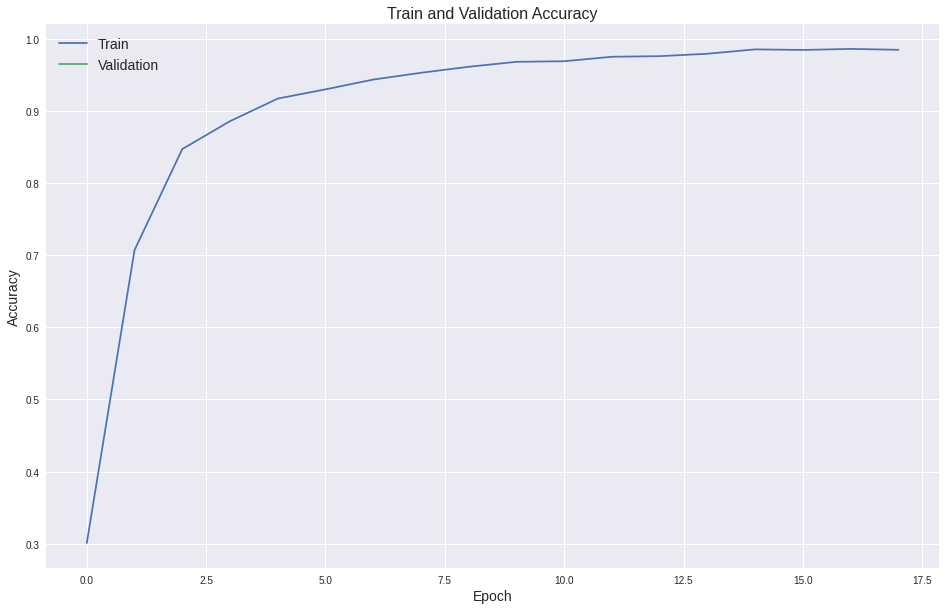

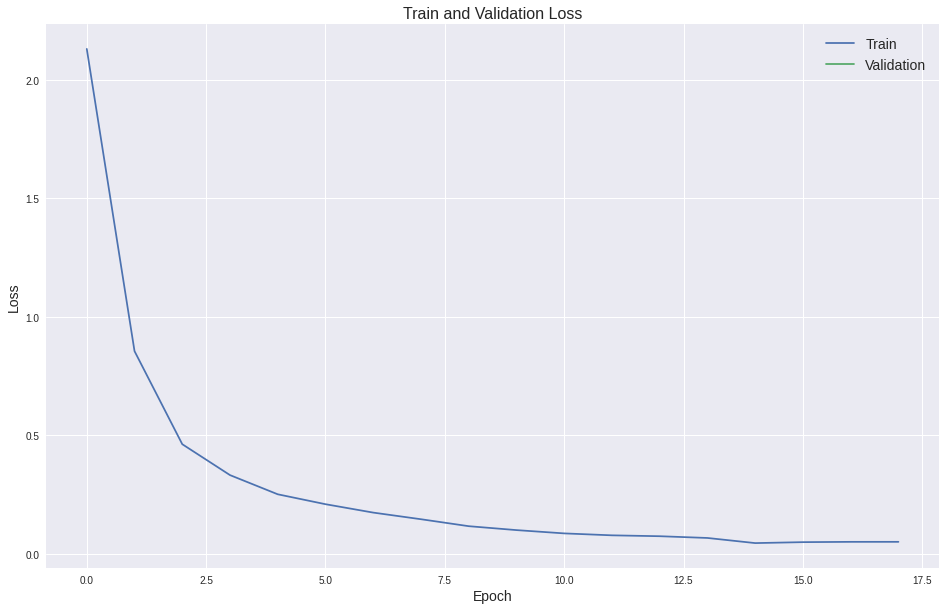

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.92      0.35      0.50        98
                 Charlock       1.00      0.98      0.99        98
                 Cleavers       1.00      0.88      0.93        98
         Common Chickweed       0.96      1.00      0.98        98
             Common wheat       0.99      0.91      0.95        98
                  Fat Hen       0.92      0.99      0.96        98
         Loose Silky-bent       0.58      0.97      0.73        98
                    Maize       0.98      0.99      0.98        98
        Scentless Mayweed       0.88      0.98      0.93        98
          Shepherds Purse       0.98      0.86      0.91        98
Small-flowered Cranesbill       0.92      0.99      0.96        98
               Sugar beet       0.96      0.95      0.95        98

                 accuracy                           0.90      1176
                macro avg       0.92  

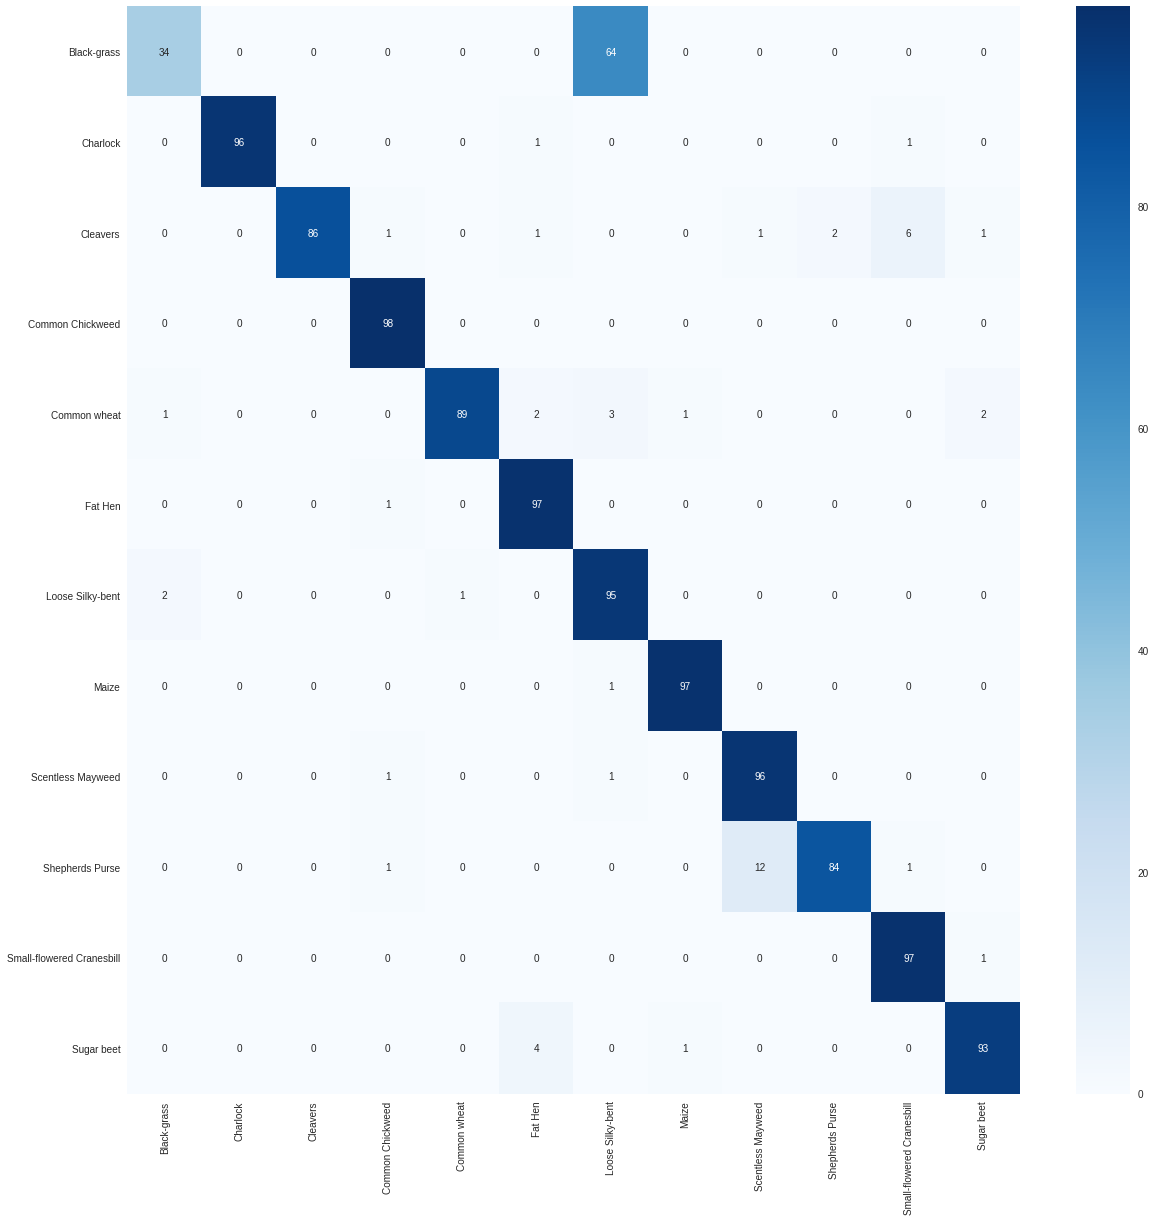

In [ ]:
# Configure model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:-11]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_vgg16 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 18,
                      verbose = 1,
                      callbacks = [reduce_lr, early_stop])

# Save the model
model.save(model_save_path)

# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_vgg16, model, val_generator)